In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import shutil
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
import os
from IPython.display import clear_output
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
batch_size=16
h=224
w=224

In [3]:
dir_path = '/kaggle/working/'

for filename in os.listdir(dir_path):
    file_path = os.path.join(dir_path, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
            print(f"File {file_path} removed.")
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
            print(f"Directory {file_path} removed.")
    except Exception as e:
        print(f"Failed to delete {file_path}. Reason: {e}")


File /kaggle/working/__notebook__.ipynb removed.


In [4]:
!apt-get install tree
clear_output()
!mkdir train test val train/yes train/no test/yes test/no val/yes val/no
!tree -d

.
|-- test
|   |-- no
|   `-- yes
|-- train
|   |-- no
|   `-- yes
`-- val
    |-- no
    `-- yes

9 directories


In [5]:
path='/kaggle/input/mydataclass/brain_tumor_dataset'
for c in os.listdir(path):
    if not c.startswith('.'):
        num = len(os.listdir(path + '/' + c))
        for (n, filename) in enumerate(os.listdir(path + '/' + c)):
            img = path + '/' + c + '/' + filename
            if n < 0.6*num:
                shutil.copy(img, 'train/'+ c + '/' + filename)
            elif n < 20+(0.6*num):
                shutil.copy(img, 'test/' + c + '/' + filename)
            else:
                shutil.copy(img, 'val/'+ c + '/' + filename)

In [6]:
train = '/kaggle/working/train'
val = '/kaggle/working/val'
test= '/kaggle/working/test'
train_data = tf.keras.utils.image_dataset_from_directory(train,seed=42,image_size=(h, w),batch_size=batch_size)
val_data = tf.keras.utils.image_dataset_from_directory(val,seed=42,image_size=(h, w),batch_size=batch_size)
test_data = tf.keras.utils.image_dataset_from_directory(test,seed=42,image_size=(h, w),batch_size=batch_size)

Found 152 files belonging to 2 classes.
Found 61 files belonging to 2 classes.
Found 40 files belonging to 2 classes.


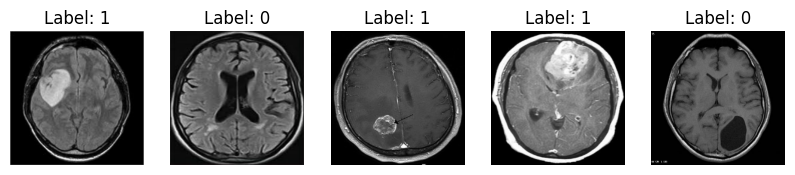

In [7]:
batch = train_data.take(1)
images, labels = next(iter(batch))
# Number of images to display
num_images = 5

# Plot the first few images
plt.figure(figsize=(10, 10))
for i in range(min(num_images, len(images))):
    ax = plt.subplot(1, num_images, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(f"Label: {labels[i].numpy()}")
    plt.axis("off")
plt.show()

In [8]:
for images, labels in train_data.take(1):
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels:", labels.numpy())
AUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.prefetch(buffer_size=AUTOTUNE)
val_data = val_data.prefetch(buffer_size=AUTOTUNE)

Images shape: (16, 224, 224, 3)
Labels shape: (16,)
Labels: [1 1 1 0 0 0 0 1 0 1 0 1 0 0 0 1]


In [9]:
base_model = ResNet50(weights='/kaggle/input/resnett/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(h, w,3), classes=2, pooling='avg')

In [10]:
for layer in base_model.layers:
    layer.trainable=False

In [11]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.3),
    tf.keras.layers.RandomContrast(0.3),
    tf.keras.layers.RandomCrop(224, 224),
    tf.keras.layers.Resizing(224, 224)  
])

In [12]:
inputs = tf.keras.Input(shape=(h, w, 3))
x = data_augmentation(inputs)
x = base_model(x) 
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,625 (90.98 MB)

 Trainable params: 262,657 (1.00 MB)

 Non-trainable params: 23,587,968 (89.98 MB)

In [14]:
history = model.fit(train_data, batch_size=batch_size, epochs=20, validation_data=val_data, shuffle=True)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 450ms/step - accuracy: 0.6560 - loss: 0.6758 - val_accuracy: 0.7869 - val_loss: 0.6146
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.7889 - loss: 0.4437 - val_accuracy: 0.8525 - val_loss: 0.4858
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.8401 - loss: 0.3791 - val_accuracy: 0.8525 - val_loss: 0.4559
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.8555 - loss: 0.3466 - val_accuracy: 0.8689 - val_loss: 0.5291
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.9082 - loss: 0.2390 - val_accuracy: 0.8525 - val_loss: 0.5127
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.8681 - loss: 0.2865 - val_accuracy: 0.8197 - val_loss: 0.3948
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.8665 - loss: 0.2618 - val_accuracy: 0.8525 - val_loss: 0.3727
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.8443 - loss: 0.2641 - val_accuracy: 0.8033 -

In [15]:
file_path = '/kaggle/working/model.h5'
try:
    if os.path.isfile(file_path) or os.path.islink(file_path):
        os.unlink(file_path)
        print(f"File {file_path} removed.")
    elif os.path.isdir(file_path):
        shutil.rmtree(file_path)
        print(f"Directory {file_path} removed.")
except Exception as e:
    print(f"Failed to delete {file_path}. Reason: {e}")


In [16]:
import pickle
pickle.dump(model,open("model.h5","wb"))

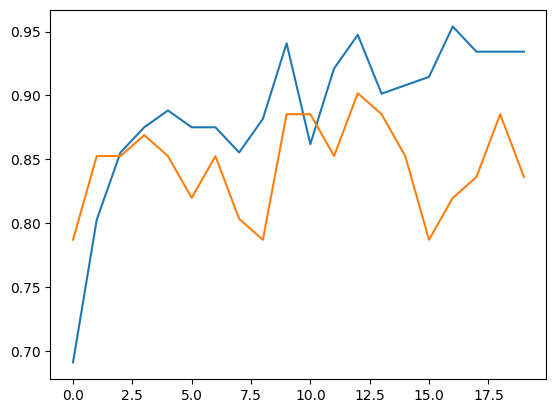

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

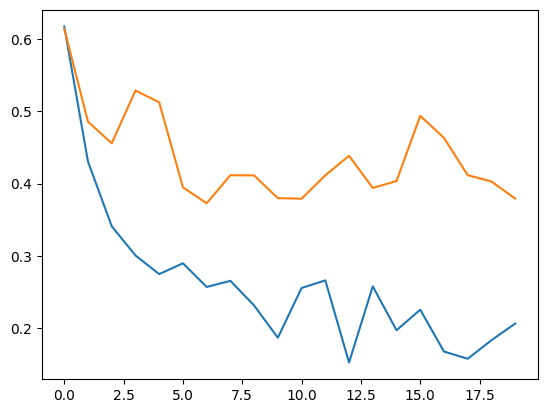

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [19]:
for c in os.listdir('/kaggle/working/test/'):
    for filename in os.listdir('/kaggle/working/test/' + c):
        img_path = '/kaggle/working/test/' + c + '/' + filename
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(h, w)) 
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        predictions = model.predict(img_array)
        predicted_class = (predictions > 0.5).astype("int32") 
        print(f"Image: {filename} Predicted class: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Image: Y71.JPG Predicted class: [[1]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Image: Y18.JPG Predicted class: [[1]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Image: Y246.JPG Predicted class: [[1]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Image: Y195.JPG Predicted class: [[1]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Image: Y65.JPG Predicted class: [[1]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Image: Y45.JPG Predicted class: [[0]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Image: Y16.JPG Predicted class: [[0]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Image: Y66.JPG Predicted class: [[1]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Image: Y245.jpg Predicted class: [[1]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Image: Y23.JPG Predicted class: [[1]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Image: Y56.jpg Predicted class: [[1]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Image: Y243.JPG Predicted class: [[1]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Image: Y193.JPG Predicted class: [[1]]
1/1 ━━━━━